# Machine Learning LAB 3: LINEAR REGRESSION

Course 2024/25: *F. Chiariotti*

The notebook contains some simple tasks to be performed with **LINEAR REGRESSION MODELS**.

Complete all the **required code sections**.

### IMPORTANT for the exam:

The functions you might be required to implement in the exam will have the same signature and parameters as the ones in the labs

## VR traffic prediction

In this notebook, we will explore the prediction of Virtual Reality (VR) traffic. The data come from the paper:

Lecci Mattia, _et al._ "An open framework for analyzing and modeling XR network traffic." IEEE Access 9 (2021): 129782-129795.

The VR game Virus Popper was instantiated on a computer through the RiftCat application: the user could then see the virtual content on their phone, which was strapped to their head with a Cardboard viewer. The file virus_popper.csv contains three columns from the traffic capture:
idx    | frame size (B) |  time (s)
0      | 38424          |  0.0
1      | 39801          |  0.01944
...

The game was run at 60 frames per second, with a target rate of 30 Mb/s. **The task is then to predict the size of the next frame, given the past N frames**. This was explored in another paper:

Chiariotti Federico, _et al._ "Temporal characterization and prediction of vr traffic: A network slicing use case." IEEE Transactions on Mobile Computing 23.5 (2023): 3890-3908.

---

## Import all the necessary Python libraries

In [8]:
import numpy as np
import pandas as pd
import random as rnd
from matplotlib import pyplot as plt
from sklearn import linear_model, preprocessing
from sklearn.model_selection import train_test_split

np.random.seed(1)

def load_dataset(filename):
    data_train = pd.read_csv(filename)
    data = data_train.iloc[:, 1].values # Get the second column (frame size) as the input
    return data

# Load the dataset
data = load_dataset('data/virus_popper.csv')

## Prepare the data and create training and test sets

In this case, we are learning a time series: let us consider a memory of 2 samples, i.e., use X[n-1] and X[n-2] to predict X[n].

In [9]:
# Normalize the dataset
avg_size = np.mean(data)
norm_data = np.asarray(data) / avg_size

# Compute the splits and prepare the columns
m_training = int(0.75*norm_data.shape[0])

X_training = np.ones([m_training - 2, 3])
X_training[:,1] = norm_data[: m_training - 2]
X_training[:,2] = norm_data[1 : m_training - 1]
Y_training = norm_data[2 : m_training]


X_test = np.ones([norm_data.shape[0] - m_training - 2, 3])
X_test[:,1] = norm_data[m_training : -2]
X_test[:,2] = norm_data[m_training + 1 : -1]
Y_test = norm_data[m_training + 2:]

print("X_training shape:", np.shape(X_training))
print("Y_training shape:", np.shape(Y_training))
print("X_test shape:", np.shape(X_test))
print("Y_test shape:", np.shape(Y_test))

print("Example of data construction")
print(X_training[:10,:]) # Columns are: one (because of homogeneous coordinates) and the previous two times step frame sizes
                            # Ys are gonna be the sizes of the frame at the current time step

X_training shape: (25878, 3)
Y_training shape: (25878,)
X_test shape: (8625, 3)
Y_test shape: (8625,)
Example of data construction
[[1.         0.64216647 0.62896851]
 [1.         0.62896851 0.627468  ]
 [1.         0.627468   0.62251473]
 [1.         0.62251473 0.58132353]
 [1.         0.58132353 0.60649324]
 [1.         0.60649324 0.60363745]
 [1.         0.60363745 0.62419271]
 [1.         0.62419271 0.61557693]
 [1.         0.61557693 0.62186936]
 [1.         0.62186936 0.64702293]]


## Least Squares linear regression

Train and evaluate the LS regressor on the data

In [10]:
# Least squares solution
def least_squares(X_matrix: np.ndarray, labels: np.ndarray):
    ## TODO: Run the LS algorithm without regularization
    A = np.dot(X_matrix.T, X_matrix) # The sum of the dot product must occur on the number of data (number of lines) which hence must be the second idx of the first vector, the first of the second one. 
    b = np.dot(labels, X_matrix) # Same here: since labels are already in column, we're good
    coeff = np.linalg.solve(A,b)
    return coeff
    
def evaluate_model(x, y, coeff):
    ## TODO: Return the average MSE for the set over which we evaluate
    mse = 0
    m = len(x)
    for i in range(m):
        mse += (np.dot(coeff, x[i,:]) - y[i])**2
    return mse/m
        

In [11]:
# Run the LS training and test it on the test data
trained_model = least_squares(X_training, Y_training)
print('Training RMSE:', np.sqrt(evaluate_model(X_training, Y_training, trained_model)) * avg_size)
mse = evaluate_model(X_test, Y_test, trained_model)
print('Model coefficients:', trained_model)
print('Root MSE:', np.sqrt(mse) * avg_size)

Training RMSE: 9070.16503921986
Model coefficients: [0.36986742 0.20348677 0.42565451]
Root MSE: 7712.354721539087


<>:3: SyntaxWarning: invalid escape sequence '\l'
<>:3: SyntaxWarning: invalid escape sequence '\l'
/var/folders/5q/jycjzrd11k1gq_4l_z12pgc00000gn/T/ipykernel_1114/906895749.py:3: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\lambda$')


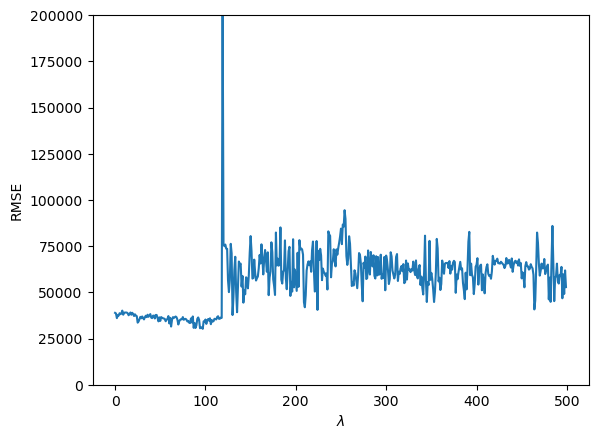

In [12]:
m=500
plt.plot(range(m), Y_training[:m] * avg_size)
plt.xlabel('$\lambda$')
plt.ylabel('RMSE')
plt.ylim([0, 200000])
plt.show()

**COMMENT:**
> Looking at the training error sample by sample we see that there are a few outliers. Due to the presence of some outliers in the training set we get this weird behavior where the test set is actually better than the training set. The same will happen in the regularized case!

---

## Least Squares with Tikhonov regularization

Perform K-fold cross validation with $\lambda\in\{0, 0.1, 1, 10\}$

NOTICE: If you want to give a look, in the teacher's solution there's a different way of implementing K fold cross validation, but it is equivalent. 

In [13]:
# Least squares solution
def regularized_least_squares(X_matrix: np.ndarray, labels: np.ndarray, lambda_par: np.ndarray) -> None:
    ## TODO: Run the LS algorithm with regularization
    A = np.dot(X_matrix.T, X_matrix) 
    A += 2*lambda_par*len(X_matrix)*np.eye(np.shape(A)[0]) #--> the teacher uses a different scaling!
    #A += lambda_par*np.eye(np.shape(A)[0])
    b = np.dot(labels, X_matrix)  
    coeff = np.linalg.solve(A,b)
    return coeff

def K_fold(X_training: np.ndarray, Y_training: np.ndarray, lambda_vec: np.ndarray, K: np.ndarray) -> None:
    ## TODO: Perform K-fold cross-validation
    x_folds = []
    y_folds = []
    m = len(X_training)
    num_points = m // K

    idx = np.arange(m)
    for k in range(K): 
        idx_fold = np.random.choice(idx, num_points, replace = False)
        idx = [i for i in idx if i not in idx_fold]
        x_folds.append(X_training[idx_fold])
        y_folds.append(Y_training[idx_fold])

    results = []
    models = []
    best_perf = 1e20
    best_model = -1
    
    for param in lambda_vec: 
        lambda_perf = 0
        for i in range(K):
            val_x = x_folds[i] 
            val_y = y_folds[i]
            train_x = np.concatenate([x_folds[j] for j in range(K) if j != i])
            train_y = np.concatenate([y_folds[j] for j in range(K) if j != i])
            lambda_k_model = regularized_least_squares(train_x, train_y, param)
            lambda_k_perf = evaluate_model(val_x, val_y, lambda_k_model)
            lambda_perf += lambda_k_perf/K
        results.append(lambda_perf)
        models.append(regularized_least_squares(X_training, Y_training, param))
        if lambda_perf < best_perf: 
            best_perf = lambda_perf
            best_model = regularized_least_squares(X_training, Y_training, param)
            
    return best_model, best_perf, models, results 

<>:11: SyntaxWarning: invalid escape sequence '\l'
<>:11: SyntaxWarning: invalid escape sequence '\l'
/var/folders/5q/jycjzrd11k1gq_4l_z12pgc00000gn/T/ipykernel_1114/2854023033.py:11: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\lambda$')


[0.36986742 0.20348677 0.42565451] [0.02142275476514418, 0.18110300511052757, 0.3476864267147456, 0.4659596940140395, 0.5508364900655802, 0.6139889615345583, 0.6625886926878817, 0.7010612109880516, 0.7322358249659671, 0.7579908565410327, 0.7796168514420332, 0.7980276068329595, 0.8138873040231629, 0.8276898062158815, 0.8398097110054058, 0.850536165046313, 0.8600958362677062, 0.8686688776353761, 0.876400247950837, 0.8834078878180041, 0.8897887223964889, 0.8956231348415986, 0.9009783456204492, 0.905910997159305, 0.9104691532915197, 0.914693862257488, 0.9186203903677397, 0.9222792044526138, 0.9256967607600732, 0.9288961433329037, 0.9318975843096258, 0.9347188908467489, 0.9373757976319632, 0.9398822596812695, 0.9422506968903768, 0.9444921993616289, 0.9466167006511887, 0.9486331246323891, 0.950549510544594, 0.9523731199147363, 0.9541105283436588, 0.9557677045980526, 0.9573500790094243, 0.9588626028288156, 0.9603097999019848, 0.9616958117993408, 0.9630244373475599, 0.9642991673564224, 0.96552

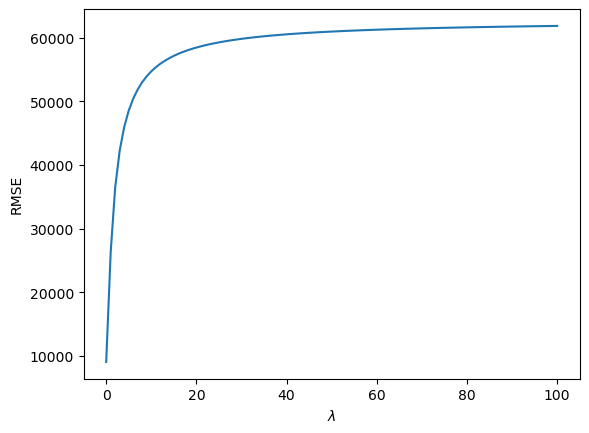

In [14]:
# Run the training with K-fold cross-validation and plot the score
K = 5
lambda_par = range(101)

best_model, best_perf, models, results = K_fold(X_training, Y_training, lambda_par, K)
print(best_model, results)

best_model, best_perf, models, results = K_fold(X_training, Y_training, lambda_par, K)
print(best_model, results)
plt.plot(lambda_par, np.sqrt(results) * avg_size)
plt.xlabel('$\lambda$')
plt.ylabel('RMSE')
plt.show()

<>:8: SyntaxWarning: invalid escape sequence '\l'
<>:8: SyntaxWarning: invalid escape sequence '\l'
/var/folders/5q/jycjzrd11k1gq_4l_z12pgc00000gn/T/ipykernel_1114/1799133235.py:8: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\lambda$')


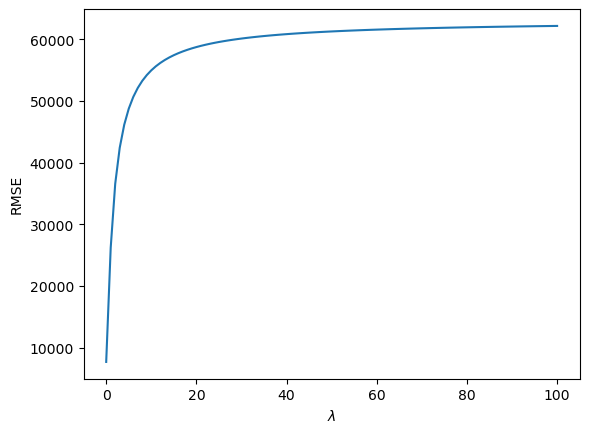

In [15]:
# Plot the results for the regularized models on the test set
test_scores = np.zeros(len(models))

for i in range(len(models)):
    test_scores[i] = evaluate_model(X_test, Y_test, models[i])

plt.plot(lambda_par, np.sqrt(test_scores) * avg_size)
plt.xlabel('$\lambda$')
plt.ylabel('RMSE')
plt.show()


**COMMENT:**
> We still have the same difference between training and test losses (as in the non-regularized case), but also we see that actually not using regularization would've been better. This is because since we have some outliers, and least-squares (with or without regularization) is sensitive to outliers (remember it's using L2 loss, the presence of these outliers led us to solutions that might not be the best. We could've had better perfomance using more robust methods that involve a different loss. 

### EXTRA

Can you figure out the best amount of memory to use?


> If we adopt a pure machine learning approach we could have basically got the result by doing **another cross validation** (trying a memory of two, three, four previous steps), increasing the number of samples.

> Actually though there is also another way to do this: we can look at the **autocorrelation of the time process**. From the article we see that the autocorrelation decreases significantly for more then three/four steps in the past. This is an indicator that probably is not very useful to look much further past that.

> Moreover, if we're doing frame size prediction, we have another way of seeing if what we did was correct or there's still something that we can use/exploit by adding some memory. This is by looking at the **autocorrelation of the residuals**: if our errors (the one at time t and the one at time t+1) are correlated with each other, this means that there is a pattern in the errors that we could've exploited if we had had more memory (and we didn't). So if you want to check if you're using all the memory needed you can do this, you should get uncorrelated errors (should soon drop to zero). 
